# Import Packages


In [ ]:
import gdown
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import random
import sklearn
from torch.autograd import Variable
import matplotlib.pyplot as plt

from torch.optim import *


In [ ]:
myseed = 0  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(myseed)
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Dataset

這邊已經將data全部都處理好了


In [ ]:
class myDataset(Dataset):
  def __init__(self, path , mode='train'):
    self.mode=mode
    data=pd.read_csv(path)
    data=data.fillna('N')
    # data=data.drop(['flbmk','flg_3dsmk'],axis=1)#missing values直接整個feature drop掉
    data = pd.get_dummies(data)#one-hot encoding將非數字轉成1數字

    if mode in ['train','val']:

      ##平衡data數量
      positive_indices = np.array(data[data.fraud_ind == 1].index)#盜刷idx 較少

      normal_indices = data[data.fraud_ind == 0].index#沒盜刷idx
      random_normal_indices = np.random.choice(normal_indices, len(positive_indices), replace = False)#從沒盜刷中隨機抽樣，使得 盜刷和沒盜刷一樣多
      random_normal_indices = np.array(random_normal_indices)

      under_sample_indices = np.concatenate([positive_indices,random_normal_indices])#合併idx
      data=data.iloc[under_sample_indices , :]

      ####################################################################
      target=data['fraud_ind']
      data=data.drop('fraud_ind',axis=1)#將target從train中刪除

      data=data.values#將data轉成numpy
      target=target.values#將target轉成numpy

      #打亂data，怕data有按照順序 ，target要記得也改 ，他們是一組的
      random_index=[i  for i in range(len(data))]
      random.shuffle(random_index)
      data=data[random_index]
      target=target[random_index]

      if mode=='train':
        indices=[i  for i in range(len(data)) if i%10 != 0 ]
      elif mode=='val':
        indices=[i  for i in range(len(data)) if i%10 == 0 ]
      self.data =torch.FloatTensor( data[indices] )
      self.target =torch.LongTensor( target[indices] )

      print(f'{mode}_data 有{self.data.shape[0]}筆資料，每筆 dim={self.data.shape[1]}')
    elif mode == 'test':
      target=data['fraud_ind']
      data=data.drop('fraud_ind',axis=1)#將target從test中刪除

      data=data.values#將data轉成numpy
      target=target.values#將target轉成numpy

      self.target =torch.LongTensor(target)
      self.data=torch.FloatTensor(data)

      print(f'{mode}_data 有{self.data.shape[0]}筆資料，每筆 dim={self.data.shape[1]}')
    self.dim = data.shape[1]
    #Normorlization
    self.data[:, :] = \
            (self.data[:, :] - self.data[:, :].mean(dim=0, keepdim=True)) \
            / self.data[:, :].std(dim=0, keepdim=True)

  def __getitem__(self, idx):
    if self.mode in ['train','val'] :
      return self.data[idx],self.target[idx]
    else:
      return self.data[idx],self.target[idx]

  def __len__(self):
    return len(self.data)

In [ ]:
def getDataLoader(path , mode ,batch_size):
  dataset = myDataset(path,mode)
  dataloader = DataLoader(dataset ,batch_size ,shuffle=(mode=='train') ,drop_last=True ,pin_memory=True)
  return dataloader

In [ ]:
tr_path="/content/gdrive/MyDrive/Colab Notebooks/金融科技導論/team/train.csv"
train_set = getDataLoader(tr_path,mode='train',batch_size=250)
val_set = getDataLoader(tr_path,mode='val',batch_size=250)

test_path="/content/gdrive/MyDrive/Colab Notebooks/金融科技導論/team/test.csv"
test_set = getDataLoader(test_path,mode='test',batch_size=250)

train_data 有27509筆資料，每筆 dim=27
val_data 有3057筆資料，每筆 dim=27
test_data 有380447筆資料，每筆 dim=27


# Cost Sensitive loss

ref:https://github.com/agaldran/cost_sensitive_loss_classification

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import scipy.stats as stats2
import sys
try:
    from kornia.losses import FocalLoss as focal_loss
except:
    pass

def get_gauss_label(label, n_classes, amplifier, noise=0):
    n = n_classes*amplifier
    half_int = amplifier/2
    label_noise = np.random.uniform(low=-noise, high=noise)
    if label == 0:
        label_noise = np.abs(label_noise)
    if label == 4:
        label_noise = -np.abs(label_noise)
    label += label_noise
    label_new = half_int + label*amplifier
    gauss_label = stats2.norm.pdf(np.arange(n), label_new, half_int/2)
    gauss_label/=np.sum(gauss_label)
    return gauss_label

def get_gaussian_label_distribution(n_classes, std=0.5):
    cls = []
    for n in range(n_classes):
        cls.append(stats2.norm.pdf(range(n_classes), 0, std))
    dists = np.stack(cls, axis=0)
    return dists

def cross_entropy_loss_one_hot(logits, target, reduction='mean'):
    logp = F.log_softmax(logits, dim=1)
    loss = torch.sum(-logp * target, dim=1)
    if reduction == 'none':
        return loss
    elif reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    else:
        raise ValueError(
            '`reduction` must be one of \'none\', \'mean\', or \'sum\'.')

def one_hot_encoding(label, n_classes):
    return torch.zeros(label.size(0), n_classes).to(label.device).scatter_(
        1, label.view(-1, 1), 1)

def label_smoothing_criterion(alpha=0.1, distribution='uniform', std=0.5, reduction='mean'):
    def _label_smoothing_criterion(logits, labels):
        n_classes = logits.size(1)
        device = logits.device
        # manipulate labels
        one_hot = one_hot_encoding(labels, n_classes).float().to(device)
        if distribution == 'uniform':
            uniform = torch.ones_like(one_hot).to(device)/n_classes
            soft_labels = (1 - alpha)*one_hot + alpha*uniform
        elif distribution == 'gaussian':
            dist = get_gaussian_label_distribution(n_classes, std=std)
            soft_labels = torch.from_numpy(dist[labels.cpu().numpy()]).to(device)
        else:
            raise NotImplementedError

        loss = cross_entropy_loss_one_hot(logits, soft_labels.float(), reduction)

        return loss

    return _label_smoothing_criterion

def cost_sensitive_loss(input, target, M):
    if input.size(0) != target.size(0):
        raise ValueError('Expected input batch_size ({}) to match target batch_size ({}).'
                         .format(input.size(0), target.size(0)))
    device = input.device
    M = M.to(device)
    return (M[target, :]*input.float()).sum(axis=-1)
    # return torch.diag(torch.matmul(input, M[:, target]))

class CostSensitiveLoss(nn.Module):
    def __init__(self,  n_classes, exp=1, normalization='softmax', reduction='mean'):
        super(CostSensitiveLoss, self).__init__()
        if normalization == 'softmax':
            self.normalization = nn.Softmax(dim=1)
        elif normalization == 'sigmoid':
            self.normalization = nn.Sigmoid()
        else:
            self.normalization = None
        self.reduction = reduction
        x = np.abs(np.arange(n_classes, dtype=np.float32))
        M = np.abs((x[:, np.newaxis] - x[np.newaxis, :])) ** exp
        M /= M.max()
        self.M = torch.from_numpy(M)

    def forward(self, logits, target):
        preds = self.normalization(logits)
        loss = cost_sensitive_loss(preds, target, self.M)
        if self.reduction == 'none':
            return loss
        elif self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            raise ValueError('`reduction` must be one of \'none\', \'mean\', or \'sum\'.')

class CostSensitiveRegularizedLoss(nn.Module):
    def __init__(self,  n_classes=5, exp=2, normalization='softmax', reduction='mean', base_loss='ce', lambd=10):
        super(CostSensitiveRegularizedLoss, self).__init__()
        if normalization == 'softmax':
            self.normalization = nn.Softmax(dim=1)
        elif normalization == 'sigmoid':
            self.normalization = nn.Sigmoid()
        else:
            self.normalization = None
        self.reduction = reduction
        x = np.abs(np.arange(n_classes, dtype=np.float32))
        M = np.abs((x[:, np.newaxis] - x[np.newaxis, :])) ** exp

        M /= M.max()
        self.M = torch.from_numpy(M)
        self.lambd = lambd
        self.base_loss = base_loss

        if self.base_loss == 'ce':
            self.base_loss = torch.nn.CrossEntropyLoss(reduction=reduction)
        elif self.base_loss == 'ls':
            self.base_loss = label_smoothing_criterion(distribution='uniform', reduction=reduction)
        elif self.base_loss == 'gls':
            self.base_loss = label_smoothing_criterion(distribution='gaussian', reduction=reduction)
        elif self.base_loss == 'focal_loss':
            kwargs = {"alpha": 0.5, "gamma": 2.0, "reduction": reduction}
            self.base_loss = focal_loss(**kwargs)
        else:
            sys.exit('not a supported base_loss')

    def forward(self, logits, target):
        base_l = self.base_loss(logits, target)
        if self.lambd == 0:
            return self.base_loss(logits, target)
        else:
            preds = self.normalization(logits)
            loss = cost_sensitive_loss(preds, target, self.M)
            if self.reduction == 'none':
                return base_l + self.lambd*loss
            elif self.reduction == 'mean':
                return base_l + self.lambd*loss.mean()
            elif self.reduction == 'sum':
                return base_l + self.lambd*loss.sum()
            else:
                raise ValueError('`reduction` must be one of \'none\', \'mean\', or \'sum\'.')

def get_cost_sensitive_criterion(n_classes=5, exp=2):
    train_criterion = CostSensitiveLoss(n_classes, exp=exp, normalization='softmax')
    val_criterion = CostSensitiveLoss(n_classes, exp=exp, normalization='softmax')
    return train_criterion, val_criterion

def get_cost_sensitive_regularized_criterion(base_loss='ce', n_classes=5, lambd=1, exp=2):
    train_criterion = CostSensitiveRegularizedLoss(n_classes, exp=exp, normalization='softmax', base_loss=base_loss, lambd=lambd)
    val_criterion = CostSensitiveRegularizedLoss(n_classes, exp=exp, normalization='softmax', base_loss=base_loss, lambd=lambd)

    return train_criterion, val_criterion

#Model

In [ ]:
class NN(nn.Module):
  def __init__(self,input_dim=27):
    super(NN, self).__init__()
    self.net = nn.Sequential(
            nn.Linear(input_dim, 2),
          )
  def forward(self, x):
    x=self.net(x)
    # print(x.shape)
    return x

# Train

In [ ]:
model=NN(train_set.dataset.dim).to(device)

num_epochs = 20
learning_rate = 1e-4
##loss1
# criterion= nn.CrossEntropyLoss()

#loss2
# criterion = CostSensitiveLoss(n_classes)
# criterion.M = torch.tensor([[0.,1.],\
#               [1000.,0.]]) #cost-matrix
#loss3
criterion = CostSensitiveRegularizedLoss(n_classes=2, base_loss='ce', lambd=10)
criterion.M = torch.tensor([[0.,1.],\
              [1000.,0.]]) #cost-matrix


optimizer = Adam(model.parameters() , lr=learning_rate ,weight_decay=1e-3 )

num_TP : 6352,num_FP : 4547,num_FN : 7408,num_TN : 9193 
[ Train | 001/020 ] loss = 2636.62354, acc = 0.56527, F1_socre = 0.51519, Precision = 0.58281 , Recall = 0.46163
[ Valid | 001/020 ] loss = 2536.40283, acc = 0.58667, F1_socre = 0.53938, Precision = 0.59557 , Recall = 0.49287'
 
num_TP : 7252,num_FP : 4306,num_FN : 6512,num_TN : 9430 
[ Train | 002/020 ] loss = 2513.39014, acc = 0.60662, F1_socre = 0.57278, Precision = 0.62744 , Recall = 0.52688
[ Valid | 002/020 ] loss = 2408.78491, acc = 0.62833, F1_socre = 0.59587, Precision = 0.63919 , Recall = 0.55804'
 
num_TP : 8095,num_FP : 4047,num_FN : 5666,num_TN : 9692 
[ Train | 003/020 ] loss = 2389.41650, acc = 0.64680, F1_socre = 0.62502, Precision = 0.66669 , Recall = 0.58826
[ Valid | 003/020 ] loss = 2282.34009, acc = 0.66833, F1_socre = 0.64528, Precision = 0.67943 , Recall = 0.61439'
 
num_TP : 8815,num_FP : 3774,num_FN : 4948,num_TN : 9963 
[ Train | 004/020 ] loss = 2269.61035, acc = 0.68284, F1_socre = 0.66902, Precision =

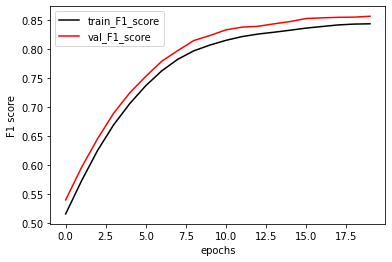

In [ ]:
steps=[]
train_F1_score=[]
val_F1_score=[]
step=0
for epoch in range(num_epochs):
  steps.append(step)
  step+=1
  ######## trainning #########
  model.train()
  train_loss = []
  train_accs = []

  num_FP=0#統計每個epoch的FP數
  num_FN=0
  num_TP=0
  num_TN=0
  for i , data in enumerate(train_set):
    inputs , labels = data
    inputs , labels = inputs.to(device), labels.to(device)

    logits = model(inputs)#預測
    #計算loss
    loss = criterion( logits , labels )#計算和真實label的loss


    prediction=logits.argmax(dim=1)#;print(prediction);print(labels)
    # TP = (  (prediction==1).int() == (labels==1).int() ).sum() #.item() #計算每個batch的TP數
    # FP = (  (prediction==1).int() == (labels==0).int() ).sum().float() #.item()
    # FN = (  (prediction==0).int() == (labels==1).int() ).sum().float() #.item()
    # num_FP += FP.detach().clone()
    # num_FN += FN.detach().clone()
    # num_TP += TP.detach().clone()


    for i in range(len(labels)):
      if prediction[i]==1 and labels[i]==1:
        num_TP+=1
      elif prediction[i]==1 and labels[i]==0:
        num_FP+=1
      elif prediction[i]==0 and labels[i]==1:
        num_FN+=1
      else:
        num_TN+=1


    # - , predicetion = torch.max( logits , 1)
    # acc = (predicetion==labels).sum().item()

    optimizer.zero_grad()#gradient歸0
    loss.backward()#計算gradient
    optimizer.step()#更新optimizer

    acc = ( prediction == labels ).float().mean()
    train_loss.append(loss)
    train_accs.append(acc)
  print(f'num_TP : {num_TP},num_FP : {num_FP},num_FN : {num_FN},num_TN : {num_TN} ')
  try:
    Precision=num_TP/(num_TP+num_FP)
    Recall=num_TP/(num_TP+num_FN)
    F1_socre=2*(Precision*Recall)/(Precision+Recall)
  except:
    Precision=0
    Recall=0
    F1_socre=0
    print("train: TP,FP,FN中某數為0")

  train_loss=sum(train_loss)/len(train_loss)#計算平均
  train_acc=sum(train_accs)/len(train_accs)#計算平均

  train_F1_score.append(F1_socre)#畫圖用
  print(f'[ Train | {epoch + 1:03d}/{num_epochs:03d} ] loss = {train_loss.item():.5f}, acc = {train_acc.item():.5f}, F1_socre = {F1_socre:.5f}, Precision = {Precision:.5f} , Recall = {Recall:.5f}')



  ######## Validation #########
  valid_loss = []
  valid_accs = []
  # TP=0  #真實為true且預測為true
  # FP=0 #真實為false且預測為true
  # FN=0  #真實為true且預測為false
  num_FP=0
  num_FN=0
  num_TP=0
  model.eval()
  for i , data in enumerate(val_set):
    inputs , labels = data
    inputs , labels = inputs.to(device), labels.to(device)

    with torch.no_grad():
      logits = model(inputs)
    loss = criterion(logits,labels)

    prediction=logits.argmax(dim=1)
    for i in range(len(labels)):
      if prediction[i]==1 and labels[i]==1:
        num_TP+=1
      elif prediction[i]==1 and labels[i]==0:
        num_FP+=1
      elif prediction[i]==0 and labels[i]==1:
        num_FN+=1

    acc = ( prediction == labels ).float().mean()
    valid_loss.append(loss)
    valid_accs.append(acc)
  try:
    Precision=num_TP/(num_TP+num_FP)
    Recall=num_TP/(num_TP+num_FN)
    F1_socre=2*(Precision*Recall)/(Precision+Recall)

  except:
    Precision=0
    Recall=0
    F1_socre=0
    print("test : TP,FP,FN中某數為0")

  valid_loss=sum(valid_loss)/len(valid_loss)
  valid_acc=sum(valid_accs)/len(valid_accs)
  val_F1_score.append(F1_socre)
  print(f"[ Valid | {epoch + 1:03d}/{num_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}, F1_socre = {F1_socre:.5f}, Precision = {Precision:.5f} , Recall = {Recall:.5f}'")
  print(' ')



plt.plot(steps,train_F1_score,color='black',label="train_F1_score")
plt.plot(steps,val_F1_score,color='red',label="val_F1_score")
plt.xlabel('epochs')
plt.ylabel('F1 score')
plt.legend()#顯示圖示
plt.show()

# Test

In [ ]:
# model.eval()
# test_losss = []
# test_accs = []
# TP=0  #真實為true且預測為true
# FP=0 #真實為false且預測為true
# FN=0  #真實為true且預測為false
# for i , data in enumerate(test_set):
#   inputs , labels = data
#   inputs , labels = inputs.to(device), labels.to(device)

#   with torch.no_grad():
#     logits = model(inputs)
#     loss = criterion(logits,labels.long())

#     prediction=logits.argmax(dim=1)
#     # TP += (  (predicetion==1).int() == (labels==1).int() ).sum().item()
#     # FP += (  (predicetion==1).int() == (labels==0).int() ).sum().item()
#     # FN += (  (predicetion==0).int() == (labels==1).int() ).sum().item()
#     for i in range(len(labels)):
#       if prediction[i]==1 and labels[i]==1:
#         TP+=1
#       elif prediction[i]==1 and labels[i]==0:
#         FP+=1
#       elif prediction[i]==0 and labels[i]==1:
#         FN+=1
#     acc = ( prediction == labels ).float().mean()
#     test_losss.append(loss)
#     test_accs.append(acc)
# try:
#   Precision=TP/(TP+FP)
#   Recall=TP/(TP+FN)
#   F1_socre=2*(Precision*Recall)/(Precision+Recall)
# except:
#   Precision=0
#   Recall=0
#   F1_socre=0
#   print("test : TP,FP,FN中某數為0")

# test_loss=sum(test_losss)/len(test_losss)
# test_acc=sum(test_accs)/len(test_accs)
# print(f"[ Test : loss = {test_loss:.5f}, acc = {test_acc:.5f},F1_socre = {F1_socre:.5f}, Precision = {Precision:.5f} , Recall = {Recall:.5f}'")

